# Petri Net-Based Policy for Emergency Department Resource Optimization

## 1. Context

This notebook implements a **rule-based policy controller** derived from Petri Net analysis principles, serving as a baseline for comparison with reinforcement learning methods (DQN, PPO).

Petri Nets are a classical operations research tool used extensively in healthcare for modeling patient flow and resource allocation. Unlike RL methods that learn from data, Petri Net-based approaches encode **domain expert knowledge** into explicit rules.






### 1.1 Methodology Overview

1. **Modeling Approach**: Discrete-event simulation with rule-based control
2. **Policy Type**: Threshold-based heuristics for staffing decisions
3. **Rules Derived From**:
   - Queueing theory principles (Little's Law, M/M/c analysis)
   - Hospital best practices (staff-to-patient ratios)
   - ED operational guidelines (triage-based prioritization)

### 1.2 Expected Outcomes

As a deterministic, knowledge-driven approach, the Petri Net baseline should:
- Provide **stable, predictable performance**
- Outperform naive policies (e.g., fixed staffing)
- Potentially underperform vs. learned RL policies in dynamic scenarios

The comparison will reveal whether data-driven learning (RL) adds value over expert knowledge, or if simple rules suffice for ED operations management.

### 1.3 Policy Rules Implemented

The Petri Net-inspired controller uses the following heuristics:

1. **Queue Length Thresholds**: Add staff when queue exceeds capacity-based limits
2. **Utilization Balancing**: Maintain 70-85% resource utilization
3. **Time-of-Day Adjustment**: Pre-emptive staffing for known peak hours
4. **Triage Priority**: Strict prioritization of level 1-2 patients
5. **Abandonment Prevention**: Emergency staffing when abandonment spikes

In [ ]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================
!pip install torch numpy simpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
import logging
from typing import Dict, List, Tuple, Optional
from collections import deque
import pandas as pd

%matplotlib inline

# Import simulation components
try:
    from ed_simulation_v4 import EmergencyDepartment, SimulationConfig, ResourceType
    print("✓ ED simulation imported successfully!")
except ImportError as e:
    print(f"✗ Could not import ED simulation: {e}")

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("\nAll dependencies loaded. Ready to implement Petri Net baseline.")

✓ ED simulation imported successfully!

All dependencies loaded. Ready to implement Petri Net baseline.


## 2. Petri Net Policy Controller

In [ ]:
# ============================================================================
# PETRI NET-INSPIRED POLICY CONTROLLER
# ============================================================================

class PetriNetPolicyController:
    """
    Rule-based policy controller inspired by Petri Net analysis.

    Implements deterministic heuristics derived from:
    - Queueing theory (threshold-based control)
    - Hospital best practices (staffing ratios)
    - Operational guidelines (priority rules)
    """

    def __init__(self, config: SimulationConfig):
        self.config = config

        # Queue thresholds (derived from queueing analysis)
        #self.queue_thresholds = {
        #    ResourceType.REGISTRATION: 8,   # Low threshold (fast service)
        #    ResourceType.NURSE: 12,         # Medium threshold
        #    ResourceType.PHYSICIAN: 15,     # High threshold (bottleneck)
        #    ResourceType.RADIOLOGY: 6,      # Low threshold
        #    ResourceType.LABORATORY: 6,     # Low threshold
        #}

        self.queue_thresholds = {
            ResourceType.REGISTRATION: 3,   # Antes: 8
            ResourceType.NURSE: 5,          # Antes: 12
            ResourceType.PHYSICIAN: 6,      # Antes: 15
            ResourceType.RADIOLOGY: 3,      # Antes: 6
            ResourceType.LABORATORY: 3,     # Antes: 6
        }


        # Target utilization range (70-85% is optimal per queueing theory)
        self.target_util_min = 0.70
        self.target_util_max = 0.75 #try 0.85

        # Abandonment threshold for emergency action
        #self.abandonment_threshold = 0.15  # 15% triggers emergency response
        self.abandonment_threshold = 0.05

        # Historical tracking for trend analysis
        self.queue_history = {rt: deque(maxlen=3) for rt in ResourceType}
        self.abandonment_history = deque(maxlen=5)

        logger.info("Petri Net Policy Controller initialized")

    def get_action(self, state: Dict) -> int:
        """
        Selects action based on deterministic rules.

        Args:
            state: ED state dict from get_current_state()

        Returns:
            action: Integer action (0-20, same as DQN/PPO)
        """
        # Extract state components
        queues = state['queue_lengths']
        utilizations = state['resource_utilization']
        current_shift = state['current_shift']
        perf = state['performance_metrics']

        # Update history
        for rt in ResourceType:
            self.queue_history[rt].append(queues[rt.value])
        self.abandonment_history.append(perf['abandonment_rate'])

        # RULE 1: Emergency staffing if abandonment is high
        if perf['abandonment_rate'] > self.abandonment_threshold:
            action = self._emergency_staffing_action(queues, utilizations)
            logger.debug(f"Emergency staffing: abandonment={perf['abandonment_rate']:.2%}")
            return action

        # RULE 2: Proactive staffing for peak hours (shift 1 = peak)
        if current_shift == 1:
            action = self._peak_hour_staffing(queues, utilizations)
            if action != 0:
                logger.debug(f"Peak hour adjustment: shift={current_shift}")
                return action

        # RULE 3: Queue-based threshold control (main logic)
        action = self._threshold_based_staffing(queues, utilizations)
        if action != 0:
            logger.debug(f"Threshold staffing: queues={queues}")
            return action

        # RULE 4: Utilization balancing (reduce if underutilized)
        action = self._utilization_balancing(queues, utilizations)
        if action != 0:
            logger.debug(f"Utilization balancing: utils={utilizations}")
            return action

        # RULE 5: Trend-based adjustment (growing queues)
        action = self._trend_based_adjustment(queues)
        if action != 0:
            logger.debug(f"Trend adjustment")
            return action

        # Default: no action
        return 0

    def _emergency_staffing_action(self, queues: Dict, utilizations: Dict) -> int:
        """Emergency: Add +2 staff to most congested resource"""
        # Find resource with highest queue relative to threshold
        max_pressure = -1
        target_resource = None

        for rt in ResourceType:
            queue_pressure = queues[rt.value] / self.queue_thresholds[rt]
            if queue_pressure > max_pressure and utilizations[rt.value] > 0.8:
                max_pressure = queue_pressure
                target_resource = rt

        if target_resource is None:
            return 0

        # Map resource to +2 action (actions 11-15)
        resource_to_action = {
            ResourceType.REGISTRATION: 11,
            ResourceType.NURSE: 12,
            ResourceType.PHYSICIAN: 13,
            ResourceType.RADIOLOGY: 14,
            ResourceType.LABORATORY: 15,
        }

        return resource_to_action[target_resource]

    def _peak_hour_staffing(self, queues: Dict, utilizations: Dict) -> int:
        """Proactively add staff during known peak hours"""
        # Add +1 to physician (bottleneck) if not already saturated
        if utilizations['physician'] < 0.95:
            return 3  # +1 physician (action 3)
        return 0

    def _threshold_based_staffing(self, queues: Dict, utilizations: Dict) -> int:
        """Core logic: Add staff when queues exceed thresholds"""
        for rt in ResourceType:
            queue_len = queues[rt.value]
            threshold = self.queue_thresholds[rt]
            util = utilizations[rt.value]

            # Add +1 if queue > threshold AND utilization > 85%
            if queue_len > threshold and util > 0.85:
                resource_to_action = {
                    ResourceType.REGISTRATION: 1,
                    ResourceType.NURSE: 2,
                    ResourceType.PHYSICIAN: 3,
                    ResourceType.RADIOLOGY: 4,
                    ResourceType.LABORATORY: 5,
                }
                return resource_to_action[rt]

        return 0

    def _utilization_balancing(self, queues: Dict, utilizations: Dict) -> int:
        """Reduce staff if utilization too low (efficiency)"""
        for rt in ResourceType:
            util = utilizations[rt.value]
            queue_len = queues[rt.value]

            # Remove -1 if utilization < 60% AND queue is small
            if util < 0.60 and queue_len < self.queue_thresholds[rt] * 0.5:
                resource_to_action = {
                    ResourceType.REGISTRATION: 6,
                    ResourceType.NURSE: 7,
                    ResourceType.PHYSICIAN: 8,
                    ResourceType.RADIOLOGY: 9,
                    ResourceType.LABORATORY: 10,
                }
                return resource_to_action[rt]

        return 0

    def _trend_based_adjustment(self, queues: Dict) -> int:
        """Add staff if queues are consistently growing"""
        for rt in ResourceType:
            history = list(self.queue_history[rt])
            if len(history) >= 3:
                # Check if queue growing for 3 consecutive steps
                if history[2] > history[1] > history[0] and history[2] > self.queue_thresholds[rt]:
                    resource_to_action = {
                        ResourceType.REGISTRATION: 1,
                        ResourceType.NURSE: 2,
                        ResourceType.PHYSICIAN: 3,
                        ResourceType.RADIOLOGY: 4,
                        ResourceType.LABORATORY: 5,
                    }
                    return resource_to_action[rt]

        return 0

print("✓ Petri Net Policy Controller implemented")

✓ Petri Net Policy Controller implemented


## Test Run: 10 Episodes

Before full training, we verify the implementation with a short 10-episode test run to ensure:
- No runtime errors
- Proper integration with the simulation
- Reasonable reward magnitudes
- Stable training dynamics

PPO should show more stable rewards than DQN even in early episodes due to its policy gradient approach.

### Environment Wrapper for Petri Net

In [ ]:
# ============================================================================
# ENVIRONMENT WRAPPER
# ============================================================================

class PetriNetEnvironment:
    """
    Environment wrapper for Petri Net controller.
    CORRECTED: Properly extracts final metrics after episode completion.
    """

    def __init__(self, config: SimulationConfig):
        self.config = config
        self.policy = PetriNetPolicyController(config)
        self.reset()

    def reset(self) -> Dict:
        """Reset environment"""
        self.ed = EmergencyDepartment(self.config)
        self.env = self.ed.env

        # Start processes
        self.env.process(self.ed._patient_generator())
        self.env.process(self.ed._shift_manager())
        self.env.process(self.ed._monitor())

        # State tracking
        self.current_step = 0
        self.prev_completed = 0
        self.prev_abandoned = 0
        self.prev_queue = 0
        self.episode_reward = 0
        self.ed.episode_count += 1

        return self.ed.get_current_state()

    def step(self) -> Tuple[Dict, float, bool, Dict]:
        """Execute one step with policy controller"""
        # Get current state
        state = self.ed.get_current_state()

        # Policy selects action
        action = self.policy.get_action(state)

        # Apply action
        self._apply_action(action)

        # Run simulation
        step_duration = 30
        target_time = self.env.now + step_duration
        self.env.run(until=min(target_time, self.config.simulation_time))

        # Check done FIRST
        done = self.env.now >= self.config.simulation_time

        # CORRECTION: Calculate final metrics BEFORE getting state
        if done:
            self.ed._calculate_final_metrics()

        # NOW get next state (with updated metrics)
        next_state = self.ed.get_current_state()

        # Calculate reward
        reward = self._calculate_reward(next_state)

        # Build info dict
        info = {
            'current_time': self.env.now,
            'episode_reward': self.episode_reward + reward,  # Include current reward
            'ed_metrics': next_state,  # Now has correct throughput/abandonment
            'action_taken': action
        }

        self.current_step += 1
        self.episode_reward += reward

        return next_state, reward, done, info

    def _apply_action(self, action: int):
        """Apply action - IDENTICAL to DQN/PPO"""
        resource_types = [
            ResourceType.REGISTRATION,
            ResourceType.NURSE,
            ResourceType.PHYSICIAN,
            ResourceType.RADIOLOGY,
            ResourceType.LABORATORY,
        ]

        if action == 0:
            return
        elif 1 <= action <= 5:
            res = resource_types[action - 1]
            self._modify_staff(res, +1)
        elif 6 <= action <= 10:
            res = resource_types[action - 6]
            self._modify_staff(res, -1)
        elif 11 <= action <= 15:
            res = resource_types[action - 11]
            self._modify_staff(res, +2)
        elif 16 <= action <= 20:
            res = resource_types[action - 16]
            self._modify_staff(res, -2)

    def _modify_staff(self, resource_type: ResourceType, change: int):
        """Modify staff"""
        current = self.ed.resources[resource_type].capacity

        max_caps = {
            ResourceType.REGISTRATION: self.config.registration_max_staff,
            ResourceType.NURSE: self.config.nurse_max_staff,
            ResourceType.PHYSICIAN: self.config.physician_max_staff,
            ResourceType.RADIOLOGY: self.config.radiology_max_staff,
            ResourceType.LABORATORY: self.config.laboratory_max_staff,
        }
        limit = max_caps[resource_type][self.ed.current_shift]

        new_capacity = min(limit, max(1, current + change))

        self.ed.resources[resource_type]._capacity = new_capacity
        self.ed.resource_states[resource_type].capacity = new_capacity

    def _calculate_reward(self, state: Dict) -> float:
        """Reward function - IDENTICAL to DQN/PPO"""
        metrics = self.ed.performance_metrics

        # Incremental metrics
        new_completed = self.ed.patients_completed - self.prev_completed
        self.prev_completed = self.ed.patients_completed

        new_abandonments = self.ed.patients_abandoned - self.prev_abandoned
        self.prev_abandoned = self.ed.patients_abandoned

        # Queue metrics
        Q_current = sum(state['queue_lengths'].values())
        Q_prev = self.prev_queue
        self.prev_queue = Q_current
        queue_growth = max(0, Q_current - Q_prev)

        # Utilization
        utilizations = list(state['resource_utilization'].values())
        avg_util = np.mean(utilizations)

        # Staff extra
        extra_staff = 0
        for resource_type, resource in self.ed.resources.items():
            baseline_staff = getattr(self.config, f"{resource_type.value}_staff")[self.ed.current_shift]
            extra_staff += max(0, resource.capacity - baseline_staff)

        # Bonuses
        util_bonus = sum(1.0 for u in utilizations if 0.60 <= u <= 0.85)

        queue_bonus = 0
        if Q_current < 15:
            queue_bonus = 3.0
        elif Q_current < 30:
            queue_bonus = 1.0

        # REWARD
        reward = (
            + 5.0 * new_completed
            - 20.0 * new_abandonments
            - 0.2 * Q_current
            - 1.0 * queue_growth
            + queue_bonus
            + util_bonus
            - 5.0 * max(0, avg_util - 0.90)
            - 3.0 * max(0, 0.40 - avg_util)
            - 1.0 * extra_staff
        )

        return np.clip(reward, -100, 100)

print("✓ Petri Net Environment implemented")

✓ Petri Net Environment implemented


### Single Episode Test (10 EP)

In [ ]:
# ============================================================================
# TEST RUN CORRECTED: 10 Episodes with Unique Seeds
# ============================================================================

print("="*80)
print("TEST RUN CORRECTED: Petri Net Policy on 10 episodes")
print("="*80)

test_rewards = []
test_abandonments = []
test_throughputs = []

for episode in range(10):
    # CORRECTION: Different seed per episode
    test_config = SimulationConfig(
        simulation_time=24 * 60,
        random_seed=42 + episode,  # ← Unique seed
        arrival_rates=[18/60, 22/60, 8/60],
    )

    test_env = PetriNetEnvironment(test_config)
    state = test_env.reset()
    episode_reward = 0
    step = 0

    while True:
        state, reward, done, info = test_env.step()
        episode_reward += reward
        step += 1

        if done:
            ed_metrics = info['ed_metrics']
            perf = ed_metrics['performance_metrics']

            test_rewards.append(episode_reward)
            test_abandonments.append(perf['abandonment_rate'])
            test_throughputs.append(perf['throughput'])

            break

    print(f"Episode {episode+1:2d}/10 - "
          f"Reward: {episode_reward:7.2f}, "
          f"Steps: {step:2d}, "
          f"Abandon: {test_abandonments[-1]*100:5.1f}%, "
          f"Throughput: {test_throughputs[-1]:3.0f}")

print("\n" + "="*80)
print("TEST COMPLETED")
print("="*80)
print(f"Average reward:       {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"Average abandonment:  {np.mean(test_abandonments)*100:.2f}% ± {np.std(test_abandonments)*100:.2f}%")
print(f"Average throughput:   {np.mean(test_throughputs):.1f} ± {np.std(test_throughputs):.1f}")

TEST RUN CORRECTED: Petri Net Policy on 10 episodes
Episode  1/10 - Reward: -927.42, Steps: 48, Abandon:  38.8%, Throughput: 329
Episode  2/10 - Reward: -3227.20, Steps: 48, Abandon:  59.6%, Throughput: 208
Episode  3/10 - Reward: -3560.60, Steps: 48, Abandon:  67.3%, Throughput: 146
Episode  4/10 - Reward: -2666.20, Steps: 48, Abandon:  54.2%, Throughput: 230
Episode  5/10 - Reward: -1955.70, Steps: 48, Abandon:  47.6%, Throughput: 261
Episode  6/10 - Reward: -3388.80, Steps: 48, Abandon:  62.4%, Throughput: 155
Episode  7/10 - Reward: -818.58, Steps: 48, Abandon:  38.4%, Throughput: 337
Episode  8/10 - Reward: -933.30, Steps: 48, Abandon:  37.9%, Throughput: 339
Episode  9/10 - Reward: -2134.35, Steps: 48, Abandon:  49.9%, Throughput: 252
Episode 10/10 - Reward: -769.42, Steps: 48, Abandon:  40.5%, Throughput: 345

TEST COMPLETED
Average reward:       -2038.16 ± 1073.21
Average abandonment:  49.65% ± 10.31%
Average throughput:   260.2 ± 72.0


## 3. Full Training: Single-Seed Run

In [ ]:
# ============================================================================
# FULL EVALUATION: 100 Episodes
# ============================================================================

def evaluate_petri_net(num_episodes: int = 100, base_seed: int = 42):
    """
    Evaluate Petri Net policy over multiple episodes.

    Args:
        num_episodes: Number of evaluation episodes
        base_seed: Base random seed

    Returns:
        results: Dict with metrics
    """
    print("="*80)
    print(f"EVALUATING PETRI NET POLICY: {num_episodes} episodes")
    print("="*80)

    eval_rewards = []
    eval_abandonments = []
    eval_throughputs = []
    eval_avg_waits = []
    eval_utilizations = []

    for episode in range(num_episodes):
        config = SimulationConfig(
            simulation_time=24 * 60,
            random_seed=base_seed + episode,
            arrival_rates=[18/60, 22/60, 8/60],
        )

        env = PetriNetEnvironment(config)
        state = env.reset()
        episode_reward = 0

        while True:
            state, reward, done, info = env.step()
            episode_reward += reward

            if done:
                ed_metrics = info['ed_metrics']
                perf = ed_metrics['performance_metrics']

                eval_rewards.append(episode_reward)
                eval_abandonments.append(perf['abandonment_rate'])
                eval_throughputs.append(perf['throughput'])

                avg_wait = np.mean(perf['wait_times']) if perf['wait_times'] else 0
                eval_avg_waits.append(avg_wait)

                utils = list(ed_metrics['resource_utilization'].values())
                eval_utilizations.append(np.mean(utils))

                break

        if (episode + 1) % 10 == 0:
            recent_reward = np.mean(eval_rewards[-10:])
            recent_abandon = np.mean(eval_abandonments[-10:]) * 100
            recent_throughput = np.mean(eval_throughputs[-10:])
            print(f"Ep {episode+1:3d}/{num_episodes} | "
                  f"Reward: {recent_reward:7.2f} | "
                  f"Abandon: {recent_abandon:5.1f}% | "
                  f"Throughput: {recent_throughput:5.1f}")

    results = {
        'rewards': eval_rewards,
        'abandonments': eval_abandonments,
        'throughputs': eval_throughputs,
        'avg_waits': eval_avg_waits,
        'utilizations': eval_utilizations,
    }

    print("\n" + "="*80)
    print("EVALUATION COMPLETED")
    print("="*80)
    print(f"\nResults (Mean ± Std):")
    print(f"  Reward:       {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
    print(f"  Abandonment:  {np.mean(eval_abandonments)*100:.2f}% ± {np.std(eval_abandonments)*100:.2f}%")
    print(f"  Throughput:   {np.mean(eval_throughputs):.1f} ± {np.std(eval_throughputs):.1f}")
    print(f"  Wait Time:    {np.mean(eval_avg_waits):.2f} ± {np.std(eval_avg_waits):.2f} min")
    print(f"  Utilization:  {np.mean(eval_utilizations)*100:.2f}% ± {np.std(eval_utilizations)*100:.2f}%")

    return results

# Execute evaluation
petri_results = evaluate_petri_net(num_episodes=100, base_seed=42)

# Save results
import pickle
with open('petri_net_evaluation.pkl', 'wb') as f:
    pickle.dump(petri_results, f)
print("\nResults saved to 'petri_net_evaluation.pkl'")

EVALUATING PETRI NET POLICY: 100 episodes
Ep  10/100 | Reward: -2038.16 | Abandon:  49.6% | Throughput: 260.2
Ep  20/100 | Reward: -1596.28 | Abandon:  43.8% | Throughput: 314.7
Ep  30/100 | Reward: -1746.93 | Abandon:  46.6% | Throughput: 295.8
Ep  40/100 | Reward: -2172.65 | Abandon:  50.4% | Throughput: 259.2
Ep  50/100 | Reward: -1369.32 | Abandon:  42.0% | Throughput: 329.6
Ep  60/100 | Reward: -1605.94 | Abandon:  43.7% | Throughput: 310.2
Ep  70/100 | Reward: -778.75 | Abandon:  35.4% | Throughput: 372.6
Ep  80/100 | Reward: -2011.67 | Abandon:  48.5% | Throughput: 268.0
Ep  90/100 | Reward: -2489.91 | Abandon:  54.2% | Throughput: 227.3
Ep 100/100 | Reward: -1560.12 | Abandon:  44.3% | Throughput: 308.8

EVALUATION COMPLETED

Results (Mean ± Std):
  Reward:       -1736.97 ± 1563.90
  Abandonment:  45.87% ± 16.69%
  Throughput:   294.6 ± 131.7
  Wait Time:    11.88 ± 0.95 min
  Utilization:  37.99% ± 8.43%

Results saved to 'petri_net_evaluation.pkl'


/tmp/ipython-input-4090455712.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['Reward', 'Abandon\n(%)', 'Throughput'], patch_artist=True)


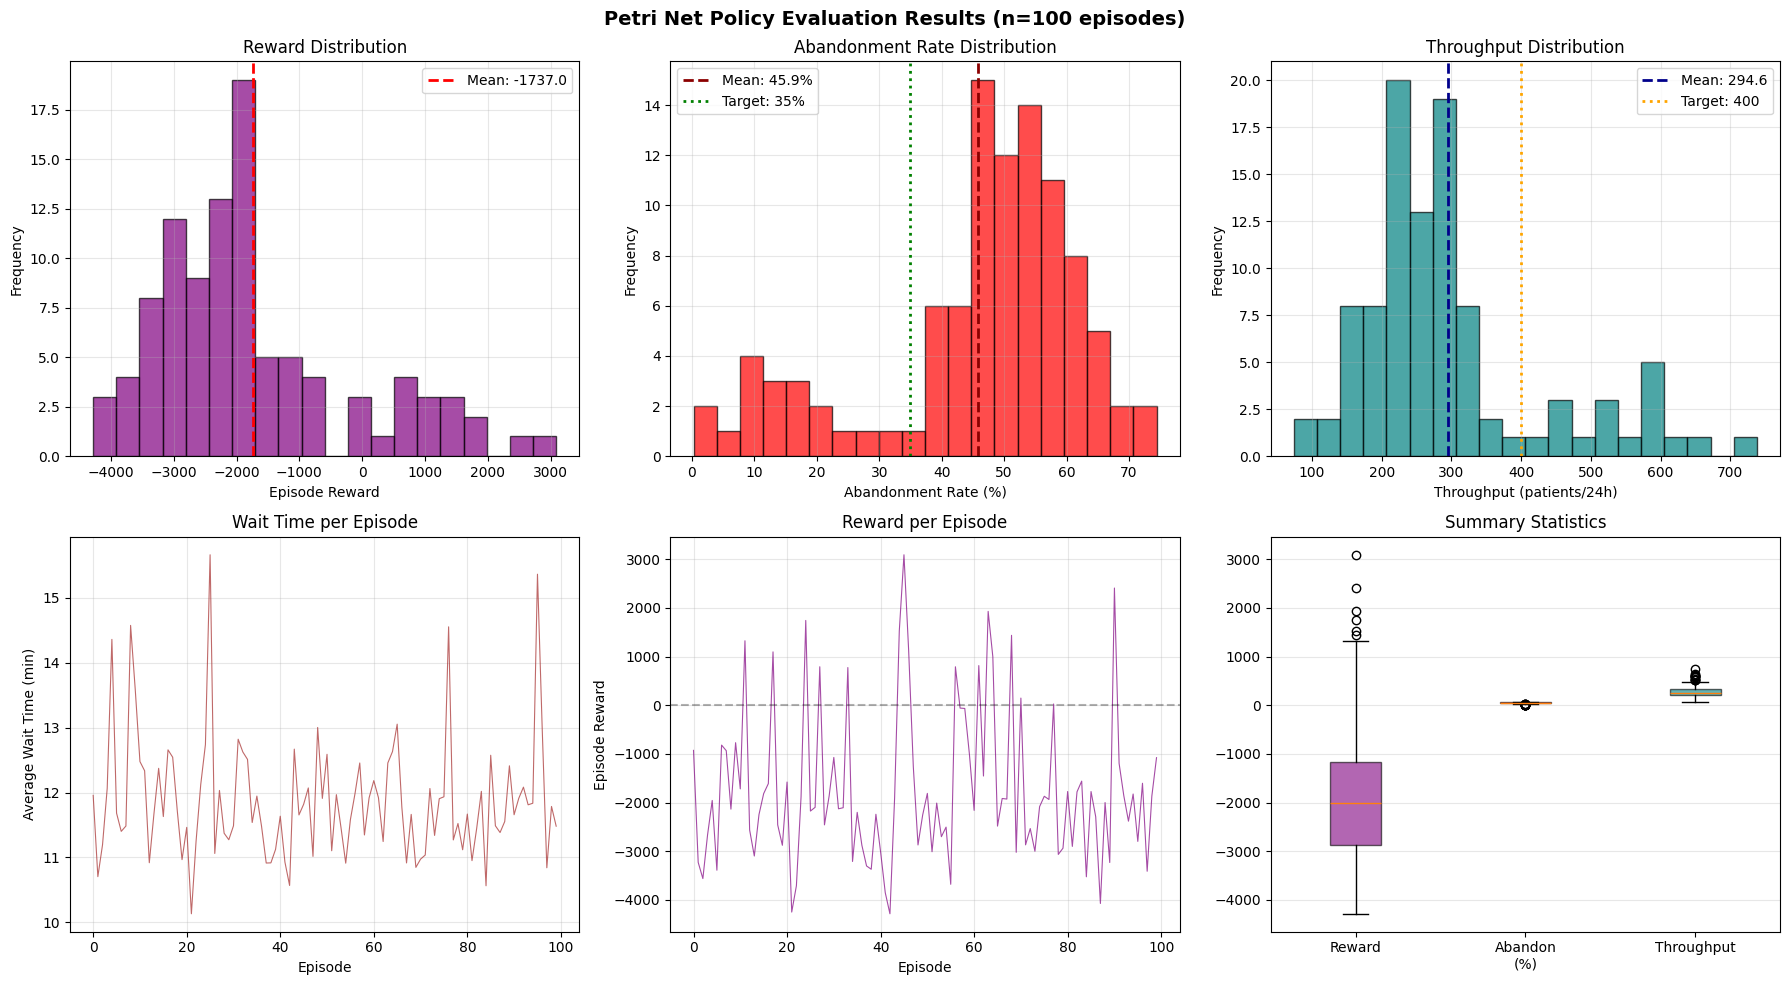

In [ ]:
# ============================================================================
# PETRI NET RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Petri Net Policy Evaluation Results (n=100 episodes)',
             fontsize=14, fontweight='bold')

# 1. Reward distribution
ax = axes[0, 0]
ax.hist(petri_results['rewards'], bins=20, alpha=0.7, color='purple', edgecolor='black')
mean_reward = np.mean(petri_results['rewards'])
ax.axvline(mean_reward, color='red', linestyle='--', linewidth=2,
           label=f"Mean: {mean_reward:.1f}")
ax.set_xlabel('Episode Reward')
ax.set_ylabel('Frequency')
ax.set_title('Reward Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Abandonment distribution
ax = axes[0, 1]
abandon_pct = np.array(petri_results['abandonments']) * 100
ax.hist(abandon_pct, bins=20, alpha=0.7, color='red', edgecolor='black')
mean_abandon = np.mean(abandon_pct)
ax.axvline(mean_abandon, color='darkred', linestyle='--', linewidth=2,
           label=f"Mean: {mean_abandon:.1f}%")
ax.axvline(35, color='green', linestyle=':', linewidth=2, label='Target: 35%')
ax.set_xlabel('Abandonment Rate (%)')
ax.set_ylabel('Frequency')
ax.set_title('Abandonment Rate Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Throughput distribution
ax = axes[0, 2]
ax.hist(petri_results['throughputs'], bins=20, alpha=0.7, color='teal', edgecolor='black')
mean_throughput = np.mean(petri_results['throughputs'])
ax.axvline(mean_throughput, color='darkblue', linestyle='--', linewidth=2,
           label=f"Mean: {mean_throughput:.1f}")
ax.axvline(400, color='orange', linestyle=':', linewidth=2, label='Target: 400')
ax.set_xlabel('Throughput (patients/24h)')
ax.set_ylabel('Frequency')
ax.set_title('Throughput Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Wait time trajectory
ax = axes[1, 0]
ax.plot(petri_results['avg_waits'], alpha=0.7, linewidth=0.8, color='brown')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Wait Time (min)')
ax.set_title('Wait Time per Episode')
ax.grid(True, alpha=0.3)

# 5. Reward trajectory
ax = axes[1, 1]
ax.plot(petri_results['rewards'], alpha=0.7, linewidth=0.8, color='purple')
ax.axhline(0, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward')
ax.set_title('Reward per Episode')
ax.grid(True, alpha=0.3)

# 6. Box plots
ax = axes[1, 2]
box_data = [
    petri_results['rewards'],
    abandon_pct,
    petri_results['throughputs'],
]
bp = ax.boxplot(box_data, labels=['Reward', 'Abandon\n(%)', 'Throughput'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['purple', 'red', 'teal']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_title('Summary Statistics')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('petri_net_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()